# Analysis of Temperature Data
A simple Raspberry Pi and DHT22 Temperature and Humidity sensor

## Import Required libraries

In [3]:
from pprint import pformat as pf, pprint as pp
import json
import logging
import os

log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

import requests
from influxdb import DataFrameClient
import pandas as pd
import numpy as np

import statsmodels
from statsmodels.tsa import stattools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import arma_generate_sample
np.random.seed(3)


import matplotlib.pyplot as plt
import itermplot
%matplotlib inline

print(os.environ.get('MPLBACKEND', ''))
print(statsmodels.__version__)
print(np.__version__)
print(pd.__version__)

module://itermplot
0.10.2
1.17.4
0.25.3


# Fetch Data

In [80]:
client = DataFrameClient(host='192.168.0.157', port=8086, database='metrics')
data =     client.query(
        '''
            SELECT 
                mean("value") 
            FROM "temperature" 
            WHERE 
                ("sensor_id" = 'RPI4-DHT22') 
                AND time >= now() - 90d 
            GROUP BY time(1h) fill(null);
        ''',
        bind_params={}, chunked=True, chunk_size=10000
    )

data = data['temperature']
data.columns = ['value']
data.describe()

,value
count,1677.000000
mean,24.513238
std,2.646040
min,17.413257
25%,22.558525
50%,24.366336
75%,26.585761
max,30.254950


In [81]:
df = data.dropna()
df_temp = df[['value']].resample('H').mean()
df_temp.index

DatetimeIndex(['2019-09-22 07:00:00+00:00', '2019-09-22 08:00:00+00:00',
               '2019-09-22 09:00:00+00:00', '2019-09-22 10:00:00+00:00',
               '2019-09-22 11:00:00+00:00', '2019-09-22 12:00:00+00:00',
               '2019-09-22 13:00:00+00:00', '2019-09-22 14:00:00+00:00',
               '2019-09-22 15:00:00+00:00', '2019-09-22 16:00:00+00:00',
               ...
               '2019-12-04 00:00:00+00:00', '2019-12-04 01:00:00+00:00',
               '2019-12-04 02:00:00+00:00', '2019-12-04 03:00:00+00:00',
               '2019-12-04 04:00:00+00:00', '2019-12-04 05:00:00+00:00',
               '2019-12-04 06:00:00+00:00', '2019-12-04 07:00:00+00:00',
               '2019-12-04 08:00:00+00:00', '2019-12-04 09:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=1755, freq='H')

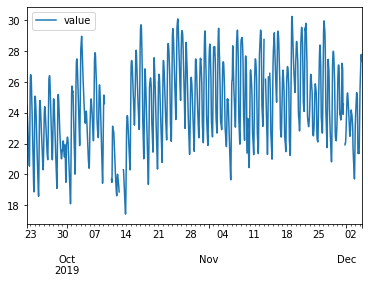

In [82]:
df_temp.plot()

# Differencing

In [83]:
df_diff = df_temp.diff().dropna()

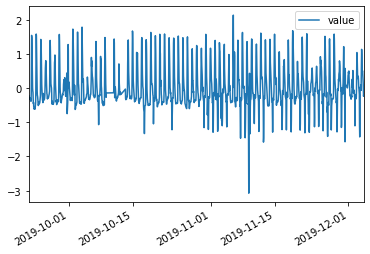

In [84]:
df_diff.plot()

# Stationarity Tests
## Augmented Dickey-Fuller Test

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html#statsmodels.tsa.stattools.adfuller

> Null Hypothesis (H0): Time Series is NOT stationary. 

**adf**: `float`

Test statistic

**pvalue**: `float`

MacKinnon’s approximate p-value based on MacKinnon (1994, 2010)

**usedlag**: `int`

Number of lags used

**nobs**: `int`

Number of observations used for the ADF regression and calculation of the critical values

**critical values**: `dict`

Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010)

**icbest**: `float`
The maximized information criterion if autolag is not None.

In [85]:
print("TEMPERATURE")
results = stattools.adfuller(df_temp['value'].dropna())

adf, pvalue, usedlag, no_obs, critical_values, ic_best = results

print(f"p-value: {pvalue}")
if pvalue < 0.05:
    print("Reject H0. Reject non-stationary. It could be stationary.")
else:
    print("Could not reject H0. It is not likely stationary.")

TEMPERATURE
p-value: 8.033963348579059e-05
Reject H0. Reject non-stationary. It could be stationary.


In [86]:
print("DIFFERENCED")
results = stattools.adfuller(df_diff['value'].dropna())

adf, pvalue, usedlag, no_obs, critical_values, ic_best = results

print(f"p-value: {pvalue}")
if pvalue < 0.05:
    print("Reject H0. Reject non-stationary. It could be stationary.")
else:
    print("Could not reject H0. It is not likely stationary.")

DIFFERENCED
p-value: 2.802822022715101e-14
Reject H0. Reject non-stationary. It could be stationary.


## KPSS Test

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.kpss.html#statsmodels.tsa.stattools.kpss

> Null Hypothesis (H0): Computes the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for the null hypothesis that x is level or trend stationary.

**kpss_stat**: `float`

The KPSS test statistic

**p_value**: `float`

The p-value of the test. The p-value is interpolated from Table 1 in Kwiatkowski et al. (1992), and a boundary point is returned if the test statistic is outside the table of critical values, that is, if the p-value is outside the interval (0.01, 0.1).

**lags**: `int`

The truncation lag parameter

**crit**: `dict`

The critical values at 10%, 5%, 2.5% and 1%. Based on Kwiatkowski et al. (1992).


In [87]:
print("TEMPERATURE")
results = stattools.kpss(df_temp['value'].dropna(), regression='ct', lags='auto')

kpss_stat, pvalue, lags, critical_values = results

print(f"p-value: {pvalue}")
if pvalue < 0.05:
    print("Reject H0. Reject stationary. It could be non-stationary.")
else:
    print("Could not reject H0. It is likely stationary.")

TEMPERATURE
p-value: 0.01
Reject H0. Reject stationary. It could be non-stationary.


/Users/jpeak/projects/temperature-timeseries/.venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [88]:
print("DIFFERENCED")
results = stattools.kpss(df_diff['value'].dropna(), regression='ct', lags='auto')

kpss_stat, pvalue, lags, critical_values = results

print(f"p-value: {pvalue}")
if pvalue < 0.05:
    print("Reject H0. Reject stationary. It could be non-stationary.")
else:
    print("Could not reject H0. It is likely stationary.")

DIFFERENCED
p-value: 0.1
Could not reject H0. It is likely stationary.


/Users/jpeak/projects/temperature-timeseries/.venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


# Auto Correlation Plots

In [89]:
df_acf = pd.DataFrame(stattools.acf(df_temp.dropna(), fft=True))

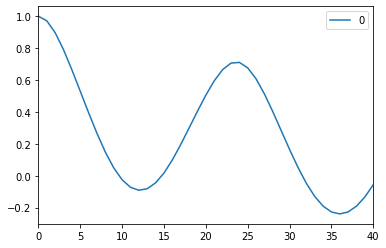

In [90]:
df_acf.plot()

In [91]:
df_pacf = pd.DataFrame(stattools.pacf(df_temp.dropna(), method='ols-inefficient'))

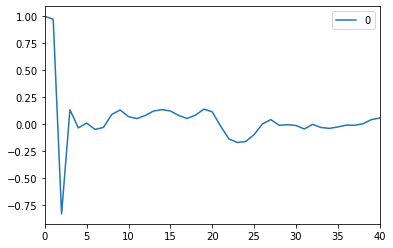

In [92]:
df_pacf.plot()

In [93]:
df_pacf[:6]

,0
0,1.000000
1,0.971443
2,-0.829595
3,0.135110
4,-0.032889
5,0.011590


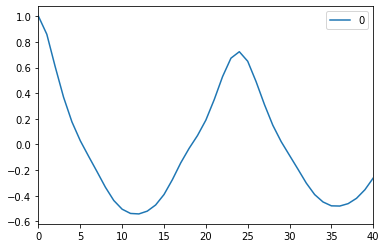

In [94]:
df_diff_acf = pd.DataFrame(stattools.acf(df_diff.dropna()))
df_diff_acf.plot()

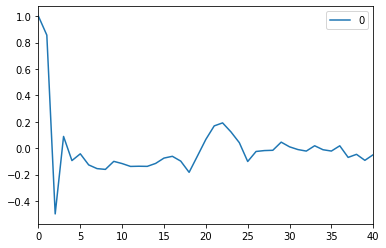

In [95]:
df_diff_pacf = pd.DataFrame(stattools.pacf(df_diff.dropna(), method='ols-inefficient'))
df_diff_pacf.plot()

## ACF

The Auto Correlation Function, has strong correlation at lags 12, 24, 36 but overall decays slowly.

## PACF

The Partial Auto Correlation function drops off rapidly after 2 lags which suggests a strong Auto Regressive relationship. 

Lets look at fitting an ARIMA model next.

# ARIMA

In [96]:
df_temp.to_csv("data.csv")

In [97]:
df_temp.index

DatetimeIndex(['2019-09-22 07:00:00+00:00', '2019-09-22 08:00:00+00:00',
               '2019-09-22 09:00:00+00:00', '2019-09-22 10:00:00+00:00',
               '2019-09-22 11:00:00+00:00', '2019-09-22 12:00:00+00:00',
               '2019-09-22 13:00:00+00:00', '2019-09-22 14:00:00+00:00',
               '2019-09-22 15:00:00+00:00', '2019-09-22 16:00:00+00:00',
               ...
               '2019-12-04 00:00:00+00:00', '2019-12-04 01:00:00+00:00',
               '2019-12-04 02:00:00+00:00', '2019-12-04 03:00:00+00:00',
               '2019-12-04 04:00:00+00:00', '2019-12-04 05:00:00+00:00',
               '2019-12-04 06:00:00+00:00', '2019-12-04 07:00:00+00:00',
               '2019-12-04 08:00:00+00:00', '2019-12-04 09:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=1755, freq='H')

In [98]:
model = SARIMAX(df_temp['value'], order=(2,1,2))
results = model.fit()

In [99]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  value   No. Observations:                 1755
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 -83.014
Date:                Wed, 04 Dec 2019   AIC                            176.028
Time:                        20:13:09   BIC                            203.376
Sample:                    09-22-2019   HQIC                           186.136
                         - 12-04-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7420      0.012    145.620      0.000       1.719       1.765
ar.L2         -0.8135      0.012    -70.329      0.000      -0.836      -0.791
ma.L1         -0.4906      0.017    -29.533      0.000      -0.523      -0.458
ma.L2         -0.4635      0.018    -25.919      0.000      -0.499      -0.428
sigma2         0.0632      0.001     51.519      0.000       0.061       0.066
===================================================================================
Ljung-Box (Q):                      423.22   Jarque-Bera (JB):              9944.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.76   Skew:                             0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

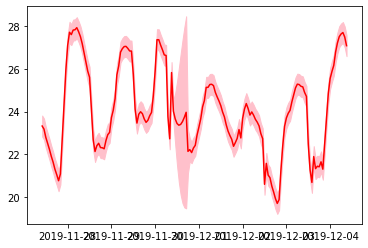

In [109]:
forecast = results.get_prediction(start=-168, dynamic=False)
# forecast = results.get_forecast(steps=24)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

plt.figure()

plt.plot(
    mean_forecast.index, 
    mean_forecast.values, 
    color='red', 
    label='forecast'
)
plt.fill_between(
    confidence_intervals.index, 
    confidence_intervals['lower value'], 
    confidence_intervals['upper value'], 
    color='pink'
)

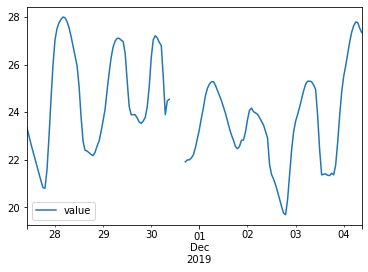

In [103]:
df_temp[-168:].plot()